#  P-median problem


In p-median problem, we place p facilities to minimize the (demand-weighted) average distance between a demand node and the location in which a facility was placed. In this model, there are no capacity constraints at the facilities.


###### Problem definition: 

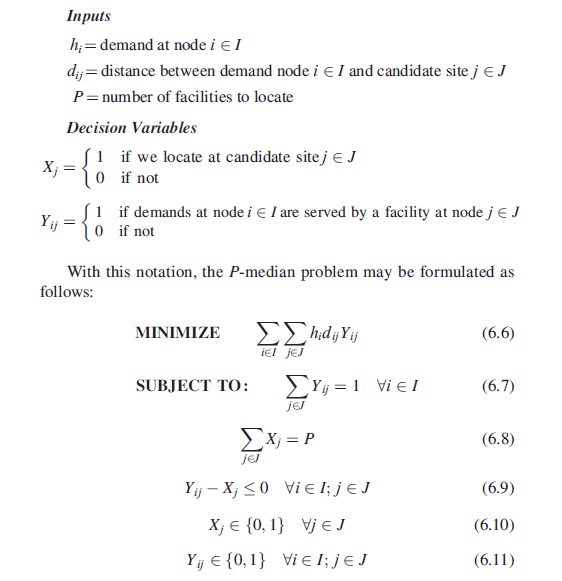

##### Solution methodology
    1. Data reading and data manipulation
    2. PL model (Calling CPLEX library)
    3. Myopic Algorithm
    4. Myopic Algorithm Improved solution (applying with PL for each neighborhood)


# 1. Data reading and data manipulation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import random
from math import radians, cos, sin, asin, sqrt
import timeit

#### 1.1 Importing Data file
###### - Link to Data source for US cities: https://simplemaps.com/data/us-cities 

In [4]:
#IMPOTINF DATA FILES
excel = pd.ExcelFile('uscities.xlsx')# open the data file

dataSet_Instance_1 = pd.read_excel(excel,'Instance_1') # reading instance-1  (75 cities)
dataSet_Instance_2 = pd.read_excel(excel,'Instance_2') # reading instance-2  (100 cities)
dataSet_Instance_3 = pd.read_excel(excel,'Instance_3') # reading instance-3  (150 cities)


In [5]:
#Here we can see the data frame for the instance - 3
dataSet_Instance_3.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking
0,Atlanta,Atlanta,GA,Georgia,13121,Fulton,33.7627,-84.4224,5449398,1441,polygon,False,True,America/New_York,1
1,Boston,Boston,MA,Massachusetts,25025,Suffolk,42.3188,-71.0846,4688346,5532,polygon,False,True,America/New_York,1
2,Phoenix,Phoenix,AZ,Arizona,4013,Maricopa,33.5722,-112.0891,4219697,1253,polygon,False,True,America/Phoenix,1
3,Denver,Denver,CO,Colorado,8031,Denver,39.7621,-104.8759,2876625,1831,polygon,False,True,America/Denver,1
4,Sacramento,Sacramento,CA,California,6067,Sacramento,38.5667,-121.4683,1898019,2029,polygon,False,True,America/Los_Angeles,1


#### 1.2 Function definition

In [6]:
# 1. This Function that calculates the distance between two points, given the latitude and longitude
from math import radians, cos, sin, asin, sqrt
# Distance between two lat/lng coordinates in km using the Haversine formula
def getDistanceFromLatLng(lat1, lng1, lat2, lng2, miles=False): # use decimal degrees
  r=6371 # radius of the earth in km
  lat1=radians(lat1)
  lat2=radians(lat2)
  lat_dif=lat2-lat1
  lng_dif=radians(lng2-lng1)
  a=sin(lat_dif/2.0)**2+cos(lat1)*cos(lat2)*sin(lng_dif/2.0)**2
  d=2*r*asin(sqrt(a))
  if miles:
    return d * 0.621371 # return miles
  else:
    return d # return km


# 2. A Function that enumerate the numbers of cities in the data frame
def nodeCities_f(dataSet):
    nodeCities = [i for i in range(len(dataSet['city']))]
    return nodeCities

# 3. This Function assign a random demand for each city in the data frame (50 to 100) units
def demand_f(dataSet):
    random.seed(30)
    a=nodeCities_f(dataSet)
    demand = [random.randint(50,100) for i in nodeCities_f(dataSet)]
    return demand

# 4. This function enumerates the candidate's places to locate the facility
def places_f(dataSet):    
    places = {i for i in nodeCities_f(dataSet)}
    return places

# 5. This function defines the arcs between the different cities
def arcs_f(dataSet):
    arcs =  [(i,j)for i in nodeCities_f(dataSet) for j in places_f(dataSet)]
    return arcs

# 6. This function determines the distance between the different cities 
def distanceArcs_f(dataSet):
    nodeCities = nodeCities_f(dataSet)
    places = places_f(dataSet)
    distanceArcs = {(i,j): getDistanceFromLatLng (dataSet['lat'][i],dataSet['lng'][i],dataSet['lat'][j],dataSet['lng'][j]) for i in nodeCities for j in places}
    return distanceArcs

# 7. This fucntion substracts and return the name and State of the city.
def cityNames_f(dataSet):
    cityNames = dataSet['state_id']+str('-')+dataSet['city']
    return cityNames

# 8. This fucntion print the graphic and the reults for the solutions 
def graphic(dataSet,actives_arcs,actives_places):
    demand=demand_f(dataSet)
    cityNames=cityNames_f(dataSet)
    nodeCities=nodeCities_f(dataSet)
    x=[]
    y=[]
    for i in nodeCities:
        x.append(radians(dataSet['lat'][i]))
        y.append(radians(dataSet['lng'][i]))

    plt.figure(figsize=(12,5))
    plt.scatter(x,y,color='blue')

    for i in range(len(x)):
        plt.annotate('$d_{%d}=%d$'%(i,demand[i]),(x[i],y[i]))

    def Color (i):
        c=['b','g','c','m','y','r','k']
        return c[i]

    for n in actives_arcs:
        i=n[0]
        j=n[1]
        plt.plot([x[i],x[j]],[y[i],y[j]], color = Color(actives_places.index(j)))

    for i in actives_places:
        plt.text(x[i]+.001, y[i]+0.1, cityNames[i], fontsize=9)

    plt.xlabel("Eje X")
    plt.xlabel("Eje Y")
    plt.xlabel("Nodos")
    plt.show()

# 2. PL model (Implementation with CPLEX library)

###### Model Implementatio (Take into account that CPLEX limit the size of the problem to 100 instances, so more than this it is not possible to obtain a solution)

In [7]:
# This function takes a data frame and a number of facility to be located, and then return the optimal cost 
# and the solutions.

def plModel(dataSet,p):
    from timeit import default_timer as timer

    start = timer() # initialization clock

    #crear modelo de Cplex
    mdl=Model('Pmedian')
    
    #DEFINING THE SET OF NODES, ARCS AND DEMAND
    nodeCities = nodeCities_f(dataSet) # Definig the a set of cities
    places = places_f(dataSet) # Defining a set of places
    arcs=arcs_f(dataSet)# Defininf the arcs between differents cities
    demand = demand_f(dataSet) #Defining a randon demand for differents cities
    distanceArcs= distanceArcs_f(dataSet) # Calculate the distances between different cities
    cityNames=cityNames_f(dataSet) # Determine the name and state of nodes
    
    # DEFINING THE DECISION VARIABLES
    Y = mdl.binary_var_dict(arcs,name = 'Y')
    X = mdl.binary_var_dict(places,name = 'X')

    #DEFINING THE OBJECTIVE FUNCTION
    mdl.minimize(mdl.sum(distanceArcs[i,j]*Y[i,j]*demand[i]  for j in places for i in nodeCities))

    #CONSTRAINTS (Please see the mathematical model shown before)

    mdl.add_constraints(mdl.sum(Y[i,j] for j in places)==1 for i in nodeCities) #Constraint 6.7

    mdl.add_constraint(mdl.sum(X[j] for j in places)==p) # Constrantint (6.8)

    mdl.add_constraints(Y[i,j] - X[j] <= 0 for i in nodeCities for j in places)# Constrint 6.9
    
    solucion = mdl.solve(log_output=False) # Solving the model
    
    #mdl.get_solve_status()
    
    c = solucion.objective_value # Store the solution int avariable called C
    
    #solucion.display()
    #print(mdl.export_to_string())
    
    actives_arcs = [k for k in arcs if Y[k].solution_value > 0.9] # Store the selected arcs (define the city which is assigned to a particular facility)
    actives_places = [k for k in places if X[k].solution_value > 0.9] # Define the city selected to places the facility.
    CN = [cityNames[i] for i in actives_places] # Determine the names of the city where the facilities are going to be located
    
    end = timer()
    
    time = end - start
    return [p, CN, c,time,actives_arcs,actives_places]
    

[1, ['KS-Overland Park'], 8371440.596208894, 3.035967537000033]


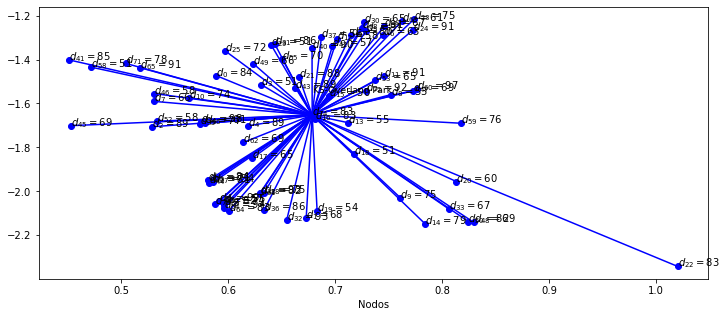

[2, ['KY-Frankfort', 'NV-Spring Valley'], 4626293.035718263, 0.8468539239993333]


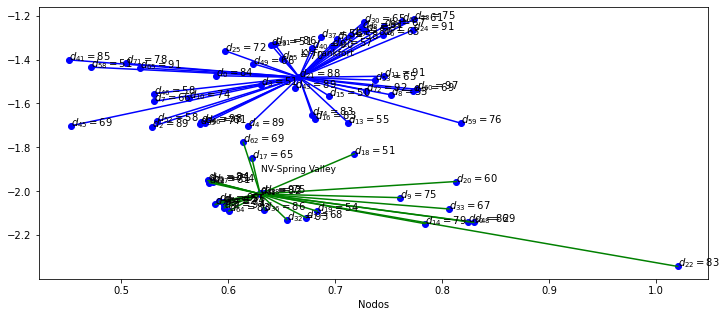

[3, ['VA-Arlington', 'NV-Spring Valley', 'TX-Frisco'], 3639502.7048531007, 0.86026884399962]


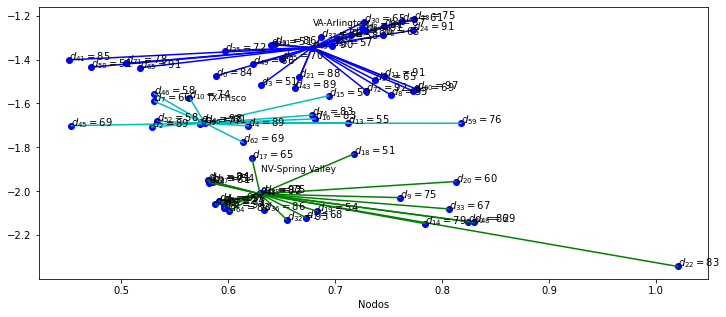

[4, ['CT-Hartford', 'KY-Frankfort', 'TX-Garland', 'NV-Spring Valley'], 3049272.851257152, 0.84938953999972]


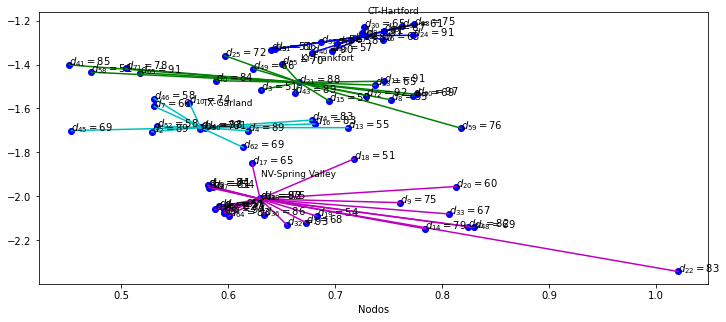

[5, ['CT-Hartford', 'KY-Frankfort', 'WA-Tacoma', 'CA-San Bernardino', 'TX-Frisco'], 2508041.7161831036, 0.7313721949994942]


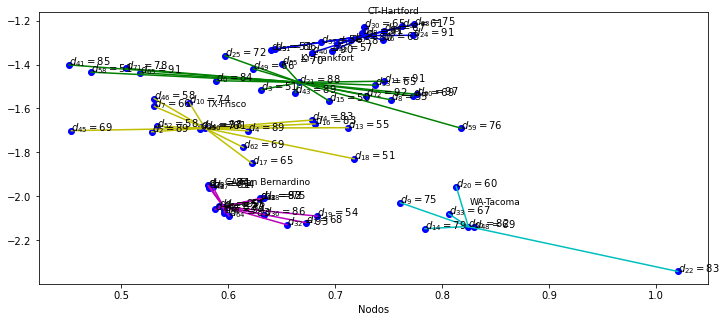

In [14]:
#Instance 1
for i in range(1,6):
    #print(i)
    print(plModel(dataSet_Instance_1,i)[0:4])
    graphic(dataSet_Instance_1,plModel(dataSet_Instance_1,i)[4],plModel(dataSet_Instance_1,i)[5])


In [22]:
#Instance 2
print('|p---|', 'Solutions---|', 'Optimal Solution---|', 'CP times|')
for i in range(1,6):
    print(plModel(dataSet_Instance_2,i)[0:4])

|p---| Solutions---| Optimal Solution---| CP times|
[1, ['MO-Cave'], 10266914.400031634, 7.906417249000697]
[2, ['KY-Lexington', 'NV-Henderson'], 6627963.516481023, 1.3898356870004136]
[3, ['VA-Richmond', 'NV-Carson City', 'MO-Springfield'], 5497074.584773598, 1.3929711820001103]
[4, ['MS-Jackson', 'DE-Dover', 'NV-Carson City', 'IL-Peoria'], 4804225.627336608, 1.3797862279998299]
[5, ['SC-Columbia', 'NV-Carson City', 'TX-Plano', 'NJ-Newark', 'IL-Peoria'], 4184186.947726513, 1.2532285070001308]


In [41]:
#Instance 3
print('|p---|', 'Solutions---|', 'Optimal Solution---|', 'CP times|')
for i in range(1,6):
    print(plModel(dataSet_Instance_3,i)[0:4])

|p---| Solutions---| Optimal Solution---| CP times|
[1, ['MO-Cave'], 10266914.400031634, 7.859770082999603]
[2, ['KY-Lexington', 'NV-Henderson'], 6627963.516481023, 1.2269895819999874]
[3, ['VA-Richmond', 'NV-Carson City', 'MO-Springfield'], 5497074.584773598, 1.3762053039999955]
[4, ['MS-Jackson', 'DE-Dover', 'NV-Carson City', 'IL-Peoria'], 4804225.627336608, 1.5269629599997643]
[5, ['SC-Columbia', 'NV-Carson City', 'TX-Plano', 'NJ-Newark', 'IL-Peoria'], 4184186.947726513, 1.4967685060000804]


# 3. Myopic Algorithm

In [8]:
# This function get a data frame and the number of facility to be located
def myopicAlgorithm(dataSet,p):
    
    from timeit import default_timer as timer
    start = timer()
    
    # DEFINING THE NUMBER OF CITIES AND DEMAND
    cityNames=list(cityNames_f(dataSet)) # Defining the de name and state of the city
    nodeCities = nodeCities_f(dataSet) # Enumerate the cities
    demand = demand_f(dataSet) # Defining the demand for each city
    places = places_f(dataSet) # Enumerate the places to locate the facilities
    
    # Detemining the distance betwenn cities
    distance_cities = [getDistanceFromLatLng(dataSet['lat'][i],dataSet['lng'][i],dataSet['lat'][j],dataSet['lng'][j]) for i in nodeCities for j in places]
    matrix = np.asarray(distance_cities,dtype= float) # Transform the list into array type  
    matrix = np.reshape(matrix,(len(nodeCities),len(nodeCities))) #Transform the Array into M X M matrix
    distanceMatrix = pd.DataFrame(matrix) # Tranform the matrix into Data Frame type
    distanceMatrix.columns = cityNames # Names the columns with the state and city name.
    distanceMatrix.index = cityNames # Names the row with the state and city name
    

     #----> measure the initial time
    
    vectorDistance = []
    namesCol = distanceMatrix.columns
    largo=len(demand)
    
    # Define a vector distance between cities
    for i in range(largo):
        vectorDistance.append({j: float(distanceMatrix[j][i]) for j in namesCol})

    #THIS FUNCTION DETERMINE THE PLACE WHERE TO LOCATED A FACILITY, GIVING A COST- DEMAND MATRIX
    def facilityLocation(lista):
        minDistance = 1000000000
        for j in namesCol:
            sumDistance = sum(lista[i][j] for i in range(len(lista))) 
            if sumDistance < minDistance:
                minDistance = sumDistance
                facil = j
            else:
                next
        return facil

    #THIS FUNCTION CALCULATES THE VALUES OF A PARTICULAR SOLUTION
    def ObjectiveFunction(lista):
        obF = []
        for j in namesCol:
            obF.append(sum(lista[i][j] for i in range(len(lista))))  
        return min(obF)


    #IMPLEMENTATION OF THE ALGORITHM 

    faciLocationIndex = [] # Definition of an array to store the name of the city where the facility must be placed
    vector = [] # This vector stores the demand  times the demand for a giving arc.
    c=0
    
    # Here we iterate and determine the cities where to locate a given number of facilities.
    while c < p: 
        for i in range(largo):
            temp = [vectorDistance[i][j] for j in faciLocationIndex]
            if len(temp)==0:
                vector.append({j: min(vectorDistance[i][j],1000000000)*demand[i] for j in namesCol})
            else:
                vector.append({j: min(vectorDistance[i][j], min(temp))*demand[i] for j in namesCol})
        faciLocationIndex.append(facilityLocation(vector))

        if c== p-1: 
            ObF=ObjectiveFunction(vector)

        vector = []

        c+=1
        
        
    # HERE, WE ASSIGN A CITY TO A FACILITY LOCATED IN A SPECIFIC CITY (CREATE THE NEIGHBORHOOD MATRIX)
    
    neighMatrix = []
    actives_arcs = []
    for i in range(largo):
        mini = min([vectorDistance[i][j] for j in faciLocationIndex])
        incre=0        
        for j in namesCol:
            if vectorDistance[i][j] == mini:
                if len(neighMatrix) > largo and sum(neighMatrix[i*largo:])>0:
                    neighMatrix.append(0)
                else:
                    neighMatrix.append(1)
                    actives_arcs.append((i,incre))
                        
            else:
                neighMatrix.append(0)
            incre+=1

    neighMatrix = np.asarray(neighMatrix,dtype= int) # Transform the list into array type  
    neighMatrix = np.reshape(neighMatrix,(largo,largo)) # Transform the neighborhood array into M x M matrix
    
    # SELECT NAMES OF THE CITIES THAT WERE SELECTED TO PLACE THE FACILITIES.
    actives_places = []    
    for item in faciLocationIndex:
        actives_places.append(cityNames.index(item))
        
    end = timer()
        
    time = end - start # CP time 
        
    return [p,faciLocationIndex,ObF, time,actives_arcs,actives_places,neighMatrix]



[1, ['KS-Overland Park'], 8371440.596208892, 0.23792648500057112]


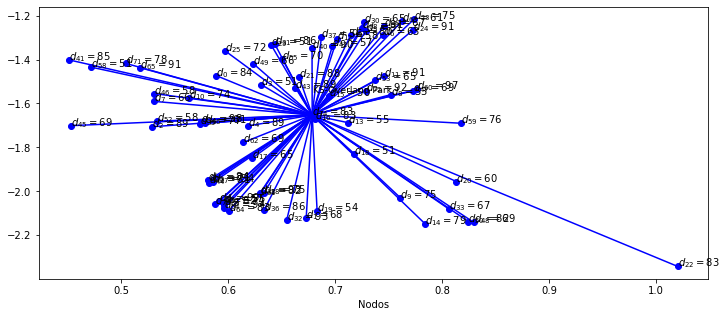

[2, ['KS-Overland Park', 'NV-Spring Valley'], 5553845.909451844, 0.31554845799837494]


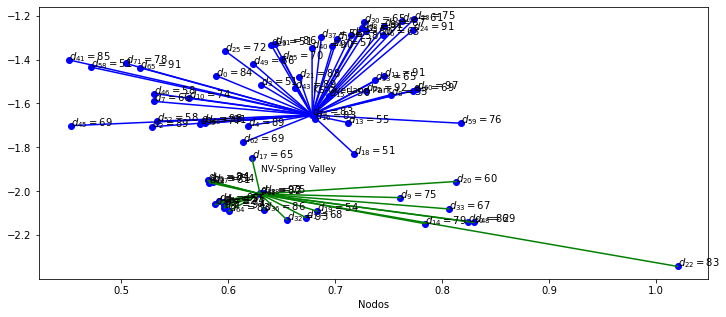

[3, ['KS-Overland Park', 'NV-Spring Valley', 'VA-Arlington'], 3670736.0325738722, 0.27493378300096083]


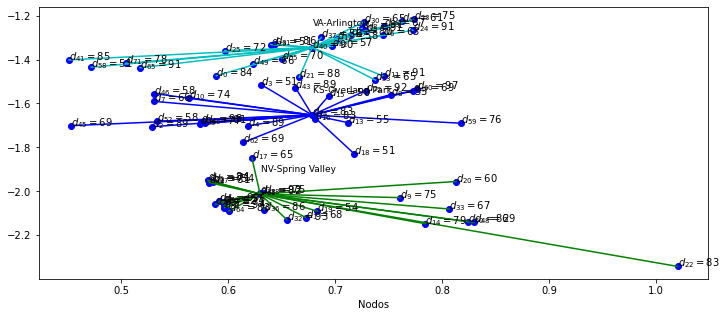

[4, ['KS-Overland Park', 'NV-Spring Valley', 'VA-Arlington', 'WA-Tacoma'], 3177177.6559312874, 0.23213121599837905]


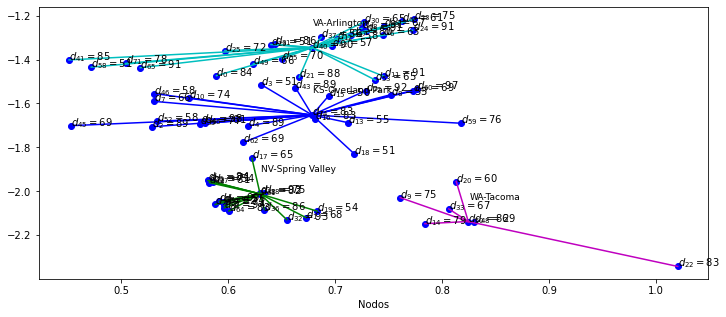

[5, ['KS-Overland Park', 'NV-Spring Valley', 'VA-Arlington', 'WA-Tacoma', 'MS-Gulfport'], 2779106.3389194296, 0.2835885020012938]


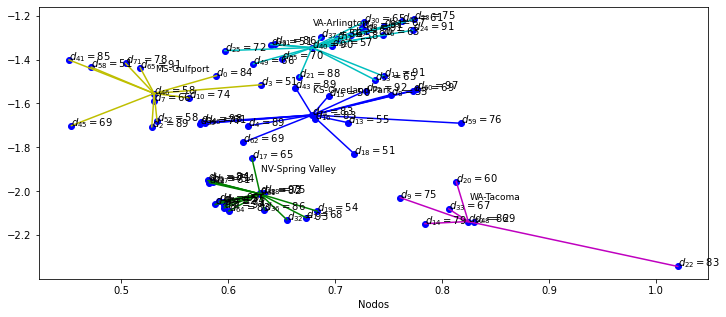

In [44]:
# EVALUATING Instance 1
for i in range(1,6):
    print(myopicAlgorithm(dataSet_Instance_1,i)[0:4])
    graphic(dataSet_Instance_1,myopicAlgorithm(dataSet_Instance_1,i)[4],myopicAlgorithm(dataSet_Instance_1,i)[5])

In [58]:
# EVALUATING Instance 3
print('|p---|', 'Solutions---|', 'Optimal Solution---|', 'CP times|')
for i in range(1,6):
    print(myopicAlgorithm(dataSet_Instance_2,i)[0:4])
    #graphic(dataSet_Instance_1,myopicAlgorithm(dataSet_Instance_1,i)[4],myopicAlgorithm(dataSet_Instance_1,i)[5])

|p---| Solutions---| Optimal Solution---| CP times|
[1, ['MO-Cave'], 10266914.400031634, 0.38215033000051335]
[2, ['MO-Cave', 'NV-Carson City'], 7273962.182590914, 0.36683892200017]
[3, ['MO-Cave', 'NV-Carson City', 'VA-Richmond'], 5549249.284070611, 0.3744052410002041]
[4, ['MO-Cave', 'NV-Carson City', 'VA-Richmond', 'TX-Plano'], 4950534.86741842, 0.38920380899980955]
[5, ['MO-Cave', 'NV-Carson City', 'VA-Richmond', 'TX-Plano', 'FL-Tallahassee'], 4497611.945838696, 0.3791296039998997]


In [59]:
# EVALUATING Instance 3
print('|p---|', 'Solutions---|', 'Optimal Solution---|', 'CP times|')
for i in range(1,6):
    print(myopicAlgorithm(dataSet_Instance_3,i)[0:4])


|p---| Solutions---| Optimal Solution---| CP times|
[1, ['MO-St. Louis'], 20819331.320558656, 1.4302843919995212]
[2, ['MO-St. Louis', 'CA-Fresno'], 13975218.370488988, 1.4423301740007446]
[3, ['MO-St. Louis', 'CA-Fresno', 'DC-Washington'], 10421142.966341013, 1.456797655999253]
[4, ['MO-St. Louis', 'CA-Fresno', 'DC-Washington', 'FL-Lakeland'], 8872217.320069415, 1.4935596260002058]
[5, ['MO-St. Louis', 'CA-Fresno', 'DC-Washington', 'FL-Lakeland', 'TX-Arlington'], 7714923.799975841, 1.5717951300011919]


In [1]:
#ini=myopicAlgorithm(dataSet_Instance_3,1)
#ini
#place_ini = ini[5]
#place_ini

#  4. Myopic Algorithm Improved solution (applying with PL for each neighborhood)

In [9]:
# This function takes the initial solutions for the Myopic algorithm, 
# and the apply PL model in each neighborhood to come up  with improved solutions
def myopicImp(dataSet,p):
    from timeit import default_timer as timer
    start = timer()
    
    ini=myopicAlgorithm(dataSet,p) # Call the Myoppic algorithm and store in 'ini' variable
    place_ini = ini[5] # Store the selected places 
    matrixNeighbor = ini[6] # Store the neighborhood matrix

    # DEFINING THE NUMBER OF CITIES AND DEMAND
    distanceArcs= distanceArcs_f(dataSet)
    nodeCities2 = nodeCities_f(dataSet)
    cityNames=cityNames_f(dataSet)
    distanceArcs= distanceArcs_f(dataSet)
    demand = demand_f(dataSet)

    # Calculating the distances 
    distance_cities = [getDistanceFromLatLng(dataSet['lat'][i],dataSet['lng'][i],dataSet['lat'][j],dataSet['lng'][j]) for i in nodeCities2 for j in nodeCities2]
    matrix = np.asarray(distance_cities,dtype= float) #Transform the list into array type  
    matrix = np.reshape(matrix,(len(nodeCities2),len(nodeCities2)))
    distanceMatrix = pd.DataFrame(matrix)
    distanceMatrix.columns = cityNames
    distanceMatrix.index = cityNames
    
    # Determining a dictionary data type for the distance vector
    vectorDistance = []
    namesCol = distanceMatrix.columns
    largo=len(demand)
    for i in range(largo):
        vectorDistance.append({j: float(distanceMatrix[j][i]) for j in namesCol})
  
    
    
    ObF = 0 # Initial values for the solution
    actives_arcs = [] # Initializaztion for the active arcs
    actives_places_l = [] # Initializaztion for the actives places
    actives_arcs_l = []
    CN= [] # vector that contains the city names
    
    # Here we iterate for the initial solutions and define a PL model for each neigborhood
    for j in place_ini:
        nodeCities = [i for i in nodeCities2 if matrixNeighbor[i][j] > 0]
        places = {i for i in nodeCities}
        arcs =  [(i,j)for i in nodeCities for j in places]
    
        mdl2=Model('Pmedian_improvement')

        Y = mdl2.binary_var_dict(arcs,name = 'Y')
        X = mdl2.binary_var_dict(places,name = 'X')

        #Funcion objetivo
        mdl2.minimize(mdl2.sum(distanceArcs[i,j]*Y[i,j]*demand[i]  for j in places for i in nodeCities))

        #restricciones

        mdl2.add_constraints(mdl2.sum(Y[i,j] for j in places)==1 for i in nodeCities) #6.7

        mdl2.add_constraint(mdl2.sum(X[j] for j in places)==1) #HACER ESTA RESTRICCION DE FORMA PARAMÉTRICA (6.8)

        mdl2.add_constraints(Y[i,j] - X[j] <= 0 for i in nodeCities for j in places)#6.9

        solucion = mdl2.solve(log_output=False)
    
        actives_arcs= [k for k in arcs if Y[k].solution_value > 0.9]
        actives_arcs_l.append(actives_arcs)
        actives_places = [k for k in places if X[k].solution_value > 0.9]
        actives_places_l.append(actives_places)
        CN.append([cityNames[i] for i in actives_places])
        
        #ObF+=c
        
    tempCN = []
    for i in CN:
        tempCN.append(i[0])
        
    tempactives_arcs_l=[]
    for i in actives_arcs_l:
        for k in i:
            tempactives_arcs_l.append(k)
        
    tempactives_places_l = []
    for i in actives_places_l:
        tempactives_places_l.append(i[0])
    
    
    #####################################################################
    #Assigning neighborhood to facility location ########################
    #####################################################################
    
    neighMatrix = []
    actives_arcs = []
    for i in range(largo):
        mini = min([vectorDistance[i][j] for j in tempCN])
        incre=0        
        for j in namesCol:
            if vectorDistance[i][j] == mini:
                if len(neighMatrix) > largo and sum(neighMatrix[i*largo:])>0:
                    neighMatrix.append(0)
                else:
                    neighMatrix.append(1)
                    actives_arcs.append((i,incre))
                        
            else:
                neighMatrix.append(0)
            incre+=1

    neighMatrix = np.asarray(neighMatrix,dtype= int) #Transform the list into array type  
    neighMatrix = np.reshape(neighMatrix,(largo,largo))
    
    actives_places = []
    cityNames=list(cityNames)
    
    for item in tempCN:
        #print(cityNames)
        actives_places.append(cityNames.index(item))
    
    OF2=0
    for i in range(largo):
        for j in range(largo):
            OF2+=neighMatrix[i][j]*matrix[i][j]*demand[i]
    
    #######################################################
    #######################################################
    
    
    
    #print(actives_arcs_l)
    
    end = timer()
    time = end - start
    if ini[2] >  OF2:
        return [p,tempCN,OF2,time,actives_arcs,actives_places]
    else:
        return ini[0:6]
    


In [63]:
# EVALUATING Instance 1
print('|p---|', 'Solutions---|', 'Optimal Solution---|', 'CP times|')
for i in range(1,6):
    print(myopicImp(dataSet_Instance_1,i)[0:4])

|p---| Solutions---| Optimal Solution---| CP times|
[1, ['KS-Overland Park'], 8371440.596208892, 0.22096135900028457]
[2, ['KY-Frankfort', 'NV-Spring Valley'], 4626293.035718264, 1.8562595570001577]
[3, ['KS-Overland Park', 'NV-Spring Valley', 'VA-Arlington'], 3670736.0325738722, 0.21375385700048355]
[4, ['KS-Overland Park', 'CA-San Bernardino', 'VA-Arlington', 'WA-Tacoma'], 3134953.478494672, 1.073779934000413]
[5, ['KS-Overland Park', 'CA-San Bernardino', 'NJ-Trenton', 'WA-Tacoma', 'MS-Gulfport'], 2672483.4326072563, 1.1687002520011447]


In [64]:
# EVALUATING Instance 2
print('|p---|', 'Solutions---|', 'Optimal Solution---|', 'CP times|')
for i in range(1,6):
    print(myopicImp(dataSet_Instance_2,i)[0:4])

|p---| Solutions---| Optimal Solution---| CP times|
[1, ['MO-Cave'], 10266914.400031634, 0.4836991760003002]
[2, ['KY-Frankfort', 'NV-Carson City'], 6644449.799535491, 4.047039262999533]
[3, ['MO-Jefferson City', 'NV-Carson City', 'VA-Richmond'], 5525124.286991865, 2.1030374500005564]
[4, ['IL-Peoria', 'NV-Carson City', 'VA-Richmond', 'TX-Plano'], 4852660.169206863, 1.8271739829997387]
[5, ['IL-Peoria', 'NV-Carson City', 'PA-Reading', 'TX-Plano', 'FL-Tallahassee'], 4266324.448331401, 1.6804294550001941]


|p---| Solutions---| Optimal Solution---| CP times|
[3, ['MO-Springfield', 'CA-Fresno', 'DC-Washington'], 10274626.610030085, 11.432310580999967]


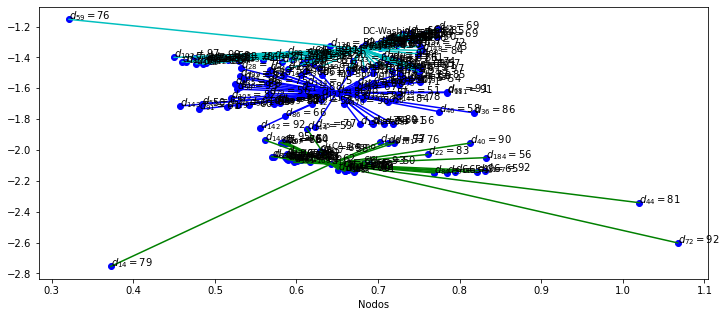

[4, ['MO-Jefferson City', 'CA-Fresno', 'PA-Reading', 'FL-Lakeland'], 8652976.798457526, 9.089633195000033]


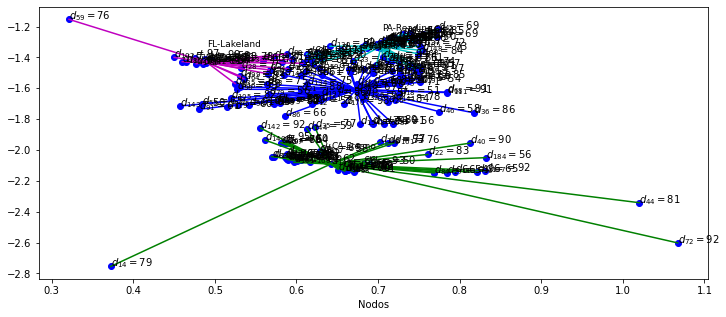

[5, ['IL-Springfield', 'CA-Fresno', 'PA-Reading', 'FL-Lakeland', 'TX-Arlington'], 7443444.288086392, 7.998760564000008]


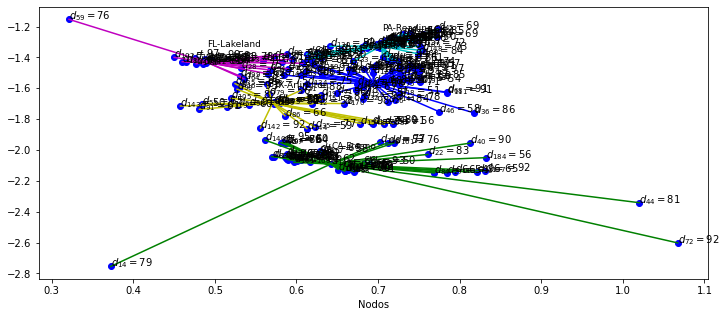

In [11]:
# EVALUATING Instance 3
print('|p---|', 'Solutions---|', 'Optimal Solution---|', 'CP times|')
for i in range(3,6):
    print(myopicImp(dataSet_Instance_3,i)[0:4])
    graphic(dataSet_Instance_3,myopicImp(dataSet_Instance_3,i)[4],myopicImp(dataSet_Instance_3,i)[5])

# Ouput solution on Excel

In [12]:
#Instance 3
incatnce3 = []
for i in range(1,6):
     incatnce3.append(myopicAlgorithm(dataSet_Instance_3,i)[0:4]) # executing myopic 
        
empDay = pd.DataFrame(incatnce3) 
empDay.columns = ['P','CITY','OF','PC TIME']
with pd.ExcelWriter('NWOP.xlsx') as writer:  # Writing the solution on Excel
    empDay.to_excel(writer, sheet_name='myopic-IN3') 



In [ ]:
#Instance 3
incatnce3 = []
for i in range(1,6):
    incatnce3.append(myopicImp(dataSet_Instance_3,i)[0:4]) # executing myopic Improvement 
    
empDay = pd.DataFrame(incatnce3) 
empDay.columns = ['P','CITY','OF','PC TIME']
with pd.ExcelWriter('NWOP.xlsx') as writer:  # Writing the solution on Excel
    empDay.to_excel(writer, sheet_name='myopicImp-IN3') #Monthly planning


# END